FIIT STU v Bratislave, ZS 2019/2020, Utorok 11:00

---

# Projekt z predmetu Inteligentná analýza údajov
### Michal Heban, Ivana Frankovičová
Datasety č. 10

---

## 3. fáza - Strojové učenie

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb;
import sklearn.metrics as sm
import re
from scipy import stats
from sklearn.impute import SimpleImputer

## Predspracovanie nových datasetov

Načítame si upravený dataset s trénovacími dátami, csv súbor s natrénovanými dátami, ktoré sme si ukladali v druhej fáze a nové datasety s validačnými a testovacími dátami, ktoré spojíme a upravíme.

In [136]:
train_dataset = pd.read_csv("merged_train.csv", lineterminator='#')

In [77]:
datasetProcessValues = pd.read_csv("trainingPreprocessData.csv", lineterminator='#')

In [76]:
other_valid = pd.read_csv("other_valid.csv", sep=',', index_col = 0)

In [80]:
personal_valid = pd.read_csv("personal_valid.csv", sep=',', index_col = 0)

In [753]:
other_test = pd.read_csv("other_test.csv", sep=',', index_col = 0)

In [752]:
personal_test = pd.read_csv("personal_test.csv", sep=',', index_col = 0)

 Nakopírovali sme si sem všetky funkcie z druhej fázy, ktoré budeme potrebovať na úpravu datasetov. Vo funkciách sme museli pridať kód na úpravu niektorých atribútov, ktoré obsahovali nullové hodnoty. Tieto atribúty nemali v trénovacom datasete nullové hodnoty a preto sme ich v druhej fáze neriešili.

In [627]:
def dateFormat(date):
    dateForm = date.replace('1', '0')
    dateForm = dateForm.replace('2', '0')
    dateForm = dateForm.replace('3', '0')
    dateForm = dateForm.replace('4', '0')
    dateForm = dateForm.replace('5', '0')
    dateForm = dateForm.replace('6', '0')
    dateForm = dateForm.replace('7', '0')
    dateForm = dateForm.replace('8', '0')
    dateForm = dateForm.replace('9', '0')
    return dateForm

In [626]:
def changeDate(date):
    datef = dateFormat(date)
    if(datef == '00-00-00'):
        day = date[6:]
        month = date[:5]
        month = month[3:]
        year = date[:2]
        firstOfYear = year[:1]
        if(firstOfYear == '1' or firstOfYear == '0'):
            year ='20'+year
        else:
            year ='19'+year
        date = year
        date = date+'-'
        date = date+month
        date = date+'-'
        date = date+day
        return date
    if(datef == '0000-00-00 00:00:00'):
        date = date[:10]
        return date
    if(datef == '00/00/0000'):
        day = date[:2]
        month = date[:5]
        month = month[3:]
        year = date[6:]
        date = year
        date = date+'-'
        date = date+month
        date = date+'-'
        date = date+day
        return date
    if(datef == '0000/00/00'):
        date = date.replace('/','-')
        return date
    if(datef == '0000-00-00 00 00 00'):
        date = date[:10]
        return date
    if(datef == '0000-00-00'):
        return date
    else:
        print('no match')
        return date

In [625]:
def changePregnantInfoFlag(flag):
    if(flag == 'F'):
        return 'f'
    if(flag == 'FALSE'):
        return 'f'
    if(flag == 'T'):
        return 't'
    if(flag == 'TRUE'):
        flag = 't'
    if(flag == 't'):
        return 't'
    if(flag == 'f'):
        return 'f'

In [624]:
def addressCorrection(address):
    address = address.replace('\r\n',' ')
    return address

In [623]:
def process_pi(text):
    if pd.isnull(text) or "undefined" in text:
        return pd.Series(["undefined"]*5)
    splitted_pi = re.split('[| \r\r\n]',text)
    splitted_pi = list(filter(None,splitted_pi))
    splitted_pi.remove("--")
    return pd.Series([splitted_pi[0],splitted_pi[1],splitted_pi[2],splitted_pi[3],splitted_pi[4]])

In [622]:
def fixSex(sex):
    sex = sex.replace(' ','')
    return sex

In [637]:
def setMissingValuesToMean(dataset,column):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean = imp_mean.fit(train_dataset[[column]])
    dataset[column] = imp_mean.transform(dataset[[column]]).ravel()

In [620]:
def setMissingValuesToMedian(dataset,column):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_mean = imp_mean.fit(train_dataset[[column]])
    dataset[column] = imp_mean.transform(dataset[[column]]).ravel()

In [655]:
def setMissingValuesToSegmentMean(dataset,column):
    meanMale = train_dataset[train_dataset['sex'] == 'Male'][column].mean()
    meanFemale = train_dataset[train_dataset['sex'] == 'Female'][column].mean()
    dataset.loc[(dataset[column].isnull()) & (dataset['sex'] == 'Male'), column] = meanMale
    dataset.loc[(dataset[column].isnull()) & (dataset['sex'] == 'Female') , column] = meanFemale

In [617]:
def setMissingValueToUndefined(dataset,column):
    dataset.loc[dataset[column].isna() , column] = 'undefined'
    dataset.loc[dataset[column] == '??',column] = 'undefined'
    dataset.loc[dataset[column] == '?',column] = 'undefined'

In [618]:
def repair_age(age):
    if pd.isnull(age):
        return pd.Series(np.nan)
    if age >= 130:
        return int(age / 100)
    if age < 0:
        return int(((age * -1) / 100))
    else:
        return int(age)

In [616]:
def getMinFromDataset(dataset,column):
    min = dataset[column].min()
    return float(min)

In [615]:
def method3(dataset,column):
    minimumValue = datasetProcessValues[column][0]
    if minimumValue < 0:
        minimumValueForLogShift = (minimumValue * -1) + 0.5
        dataset[column] = dataset[column] + minimumValueForLogShift
    dataset.dropna(subset=[column], inplace=True)
    dataset[column] = np.log(dataset[column])

In [614]:
def method1(dataset,column,minV,maxV):
    upperQ = datasetProcessValues[column][4]
    dataset.loc[dataset[column] > maxV, column] = upperQ
    
    lowerQ = datasetProcessValues[column][5]
    dataset.loc[dataset[column] < minV, column] = upperQ
    

In [613]:
def mergeDatasets(dataset1,dataset2):
    mergedDataset = pd.merge(dataset1,dataset2, on=['name','address'], how='left')
    duplicates = mergedDataset[mergedDataset.duplicated(['name', 'address','age'], keep=False)].sort_values(by = 'name')
    mergedDataset = mergedDataset.drop_duplicates(['name', 'address'], keep=False)
    names = duplicates.name.unique()

    for name in names:
        tmp = duplicates[duplicates['name'] == name]
        tmp = tmp.fillna(method='ffill')
        tmp = tmp.fillna(method='bfill')
        tmp = tmp.drop_duplicates(['name'])
        mergedDataset = mergedDataset.append(tmp, ignore_index=True)
    return mergedDataset

In [612]:
def dataFixing(dataset):
    dataset['date_of_birth'] = dataset['date_of_birth'].apply(changeDate)
    dataset['pregnant'] = dataset['pregnant'].apply(changePregnantInfoFlag)
    dataset['address'] = dataset['address'].apply(addressCorrection)
    dataset[['job','state','family_status','home','color']] = dataset['personal_info'].apply(process_pi)
    del dataset['personal_info']
    dataset['sex'] = dataset['sex'].apply(fixSex)
    dataset.loc[(dataset["sex"] == 'Male') & (dataset["pregnant"] == 't') , 'pregnant'] = 'f'
    dataset['capital'] = dataset['capital-gain'] - dataset['capital-loss']
    dataset['age'] = dataset['age'].apply(repair_age)
    del dataset["capital-gain"]
    del dataset["capital-loss"]

In [673]:
def missingDataProcessing(dataset):
    setMissingValuesToMean(dataset,'kurtosis_oxygen')
    setMissingValuesToMean(dataset,'hours-per-week')
    setMissingValuesToMean(dataset,'std_glucose')
    setMissingValuesToMean(dataset,'skewness_glucose')
    setMissingValuesToSegmentMean(dataset,'mean_glucose')
    setMissingValuesToMean(dataset,'kurtosis_glucose')
    setMissingValuesToMedian(dataset,'fnlwgt')
    setMissingValueToUndefined(dataset,'income')
    setMissingValueToUndefined(dataset,'capital')
    setMissingValueToUndefined(dataset,'job')
    setMissingValueToUndefined(dataset,'state')
    setMissingValueToUndefined(dataset,'home')
    setMissingValueToUndefined(dataset,'education')
    setMissingValueToUndefined(dataset,'relationship')
    setMissingValueToUndefined(dataset,'education-num')

In [610]:
def outlierProcessing(dataset):
    method1(dataset,'kurtosis_glucose',datasetProcessValues['kurtosis_glucose'][1],datasetProcessValues['kurtosis_glucose'][2])
    method1(dataset,'kurtosis_oxygen',datasetProcessValues['kurtosis_oxygen'][1],datasetProcessValues['kurtosis_oxygen'][2])
    method1(dataset,'mean_glucose',datasetProcessValues['mean_glucose'][1],datasetProcessValues['mean_glucose'][2])    
    method3(dataset,'mean_oxygen')
    method3(dataset,'skewness_glucose')
    method3(dataset,'skewness_oxygen')
    method1(dataset,'std_glucose',datasetProcessValues['std_glucose'][1],datasetProcessValues['std_glucose'][2])
    method1(dataset,'std_oxygen',datasetProcessValues['std_oxygen'][1],datasetProcessValues['std_oxygen'][2])

In [611]:
def finalFunction(dataset1,dataset2):
    mergedDataset = mergeDatasets(dataset1,dataset2)
    dataFixing(mergedDataset)
    missingDataProcessing(mergedDataset)
    outlierProcessing(mergedDataset)
    return mergedDataset

Funkcie máme nakopírované, môžeme upravovať datasety. Upravíme validačné datasety a testovacie datasety.

In [142]:
valid = finalFunction(personal_valid, other_valid)

C:\Users\Owner\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [420]:
test_dataset = finalFunction(personal_test, other_test)

Po úprave vidíme, že datasety sú spojené a nenachádzajú sa v nich už žiadne nullové hodnoty.

#### OneHotEncoding

In [59]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [921]:
encoder = OneHotEncoder(categories='auto')

def labelEncoder(column):
    le = preprocessing.LabelEncoder()
    return le.fit_transform(column.astype(str))

def encodeOneHot(dataset,noClass):
    col = ['sex','pregnant','family_status','color']
    
    for c in col:
        dataset[c]=labelEncoder(dataset[c])
        X = encoder.fit_transform(dataset[c].values.reshape(-1,1)).toarray()
        dfOneHot = pd.DataFrame(X, columns = [c+"_"+str(int(i)) for i in range(X.shape[1])])
        dataset = pd.concat([dataset, dfOneHot], axis=1)
        del dataset[c]
    
    if(noClass != 0):
        dataset['class']=labelEncoder(dataset['class'])
    return dataset

## Rozhodovacie pravidlá pre klasifikáciu - manuálne

Pre tvorbu rozhodovacích pravidiel pre klasifikáciu sme si vybrali atribúty mean_glucose a mean_oxygen. Vytvorili sme funkcie, ktoré predikujú, či človek má cukrovku podľa zvýšených, resp. znížených hodnôt cukru a kyslíka v krvi:

In [584]:
def predictionDiabetesFromGlucose(dataset):
    dataset.loc[dataset['mean_glucose'] < diabetesGlucoseThreshold, 'predicted'] = 1
    dataset.loc[dataset['mean_glucose'] >= diabetesGlucoseThreshold, 'predicted'] = 0

In [585]:
def predictionDiabetesFromOxygen(dataset):
    dataset.loc[dataset['mean_oxygen'] < diabetesOxygenThreshold, 'predicted'] = 0
    dataset.loc[dataset['mean_oxygen'] >= diabetesOxygenThreshold, 'predicted'] = 1

In [586]:
def predictDiabetesFromOxygenPlusGlucose(dataset):
    dataset.loc[(dataset['mean_oxygen'] < diabetesOxygenThreshold) & (dataset['mean_oxygen'] < diabetesOxygenThreshold) , 'predicted'] = 0
    dataset.loc[(dataset['mean_oxygen'] >= diabetesOxygenThreshold) & (dataset['mean_glucose'] >= diabetesGlucoseThreshold), 'predicted'] = 1

Nasledujúca funkcia slúži na výpis hodnôt accuracy, precision a recall:

In [592]:
def scoresOfPredictions(dataset,predictionDataset,typeOfData):
    name = 'validačný'
    if(typeOfData == 1):
        name = 'trénovací'
    labels = dataset['class'].values
    print('Výsledky pre '+name+' dataset')
    print("   * Accuracy score:",sm.accuracy_score(labels,predictionDataset['predicted']))
    print("   * Precision score:",sm.precision_score(labels,predictionDataset['predicted'], average='macro'))
    print("   * Recall score:",sm.recall_score(labels,predictionDataset['predicted'], average='macro'))
    print("   * F1 score:",sm.f1_score(labels, predictionDataset['predicted'], average='macro'))

### mean_glucose

In [587]:
gpd = valid.loc[valid['class'] == 1,'mean_glucose']
gnd = valid.loc[valid['class'] == 0,'mean_glucose']

(Poznámka: gpd - glucose positive diabetes, gnd - glucose negative diabetes)

Vykreslili sme si histogramy mean_glucose. Červenou farbou sú vyznačené hodnoty cukru v krvi u ľudí, ktorí majú cukrovku. Modrou farbou sú vyznačené hodnoty cukru v krvi u ľudí, ktorí cukrovku nemajú.

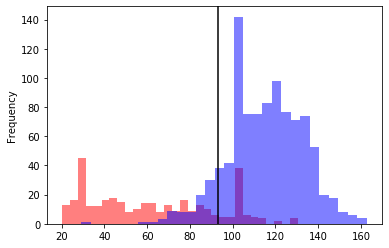

In [588]:
gpd.plot.hist(bins=30,color = 'red',alpha = 0.5)
gnd.plot.hist(bins = 30, color = 'blue',alpha = 0.5)
plt.axvline(x=93, color = 'black')
diabetesGlucoseThreshold = 93

Ako predikčnú hodnotu sme si vzali číslo 93. Vyznačili sme ho do grafu čiarou pre vizuálne rozlíšenie. 

In [589]:
predictedTrainG = train_dataset[['class','mean_glucose']].copy()
predictedValidG = valid[['class','mean_glucose']].copy()
predictedTrainG['predicted'] = 0
predictedValidG['predicted'] = 0

In [590]:
predictionDiabetesFromGlucose(predictedTrainG)
predictionDiabetesFromGlucose(predictedValidG)

Predikovali sme cukrovku u ľudí v trénovacom aj validačnom datasete. Skóre accuracy, precision a recall nám vyšli relatívne vysoké, ak teda vezmeme do úvahy, že sme použili iba jedno veľmi jednoduché pravidlo.

In [593]:
scoresOfPredictions(train_dataset,predictedTrainG,1)

Výsledky pre trénovací dataset
   * Accuracy score: 0.8759216882786677
   * Precision score: 0.8350719298771052
   * Recall score: 0.8423977357895152
   * F1 score: 0.8386137002077257


In [594]:
scoresOfPredictions(valid,predictedValidG,0)

Výsledky pre validačný dataset
   * Accuracy score: 0.8764302059496567
   * Precision score: 0.8376611999885113
   * Recall score: 0.852102488843631
   * F1 score: 0.8443741316747466


### mean_oxygen

In [595]:
opd = valid.loc[valid['class'] == 1,'mean_oxygen']
ond = valid.loc[valid['class'] == 0,'mean_oxygen']

(Poznámka: opd - oxygen positive diabetes, ond - oxygen negative diabetes)

Vykreslili sme si histogramy mean_oxygen. Červenou farbou sú vyznačené hodnoty kyslíka v krvi u ľudí, ktorí majú cukrovku. Modrou farbou sú vyznačené hodnoty kyslíka v krvi u ľudí, ktorí cukrovku nemajú.

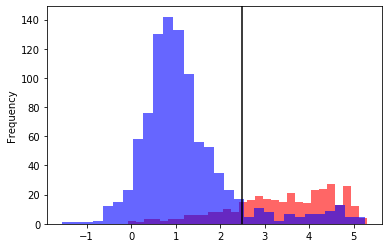

In [596]:
opd.plot.hist(bins=30,color = 'red',alpha = 0.6)
ond.plot.hist(bins = 30, color = 'blue',alpha = 0.6)
plt.axvline(x=2.5, color = 'black')
diabetesOxygenThreshold = 2.5

Ako predikčnú hodnotu sme si vzali číslo 2,5. Vyznačili sme ho do grafu čiarou pre vizuálne rozlíšenie. 

In [597]:
predictedTrainO = train_dataset[['class','mean_oxygen']].copy()
predictedValidO = valid[['class','mean_oxygen']].copy()
predictedTrainO['predicted'] = 0
predictedValidO['predicted'] = 0

In [598]:
predictionDiabetesFromOxygen(predictedTrainO)
predictionDiabetesFromOxygen(predictedValidO)

Predikovali sme cukrovku u ľudí v trénovacom aj validačnom datasete. Skóre accuracy, precision a recall nám, rovnako ako pri mean_glucose, vyšli opäť celkom vysoké. 

In [599]:
scoresOfPredictions(train_dataset,predictedTrainO,1)

Výsledky pre trénovací dataset
   * Accuracy score: 0.8728705822527333
   * Precision score: 0.8330405727923628
   * Recall score: 0.832166724022313
   * F1 score: 0.8326019404384681


In [600]:
scoresOfPredictions(valid,predictedValidO,0)

Výsledky pre validačný dataset
   * Accuracy score: 0.8756674294431731
   * Precision score: 0.8377839335180055
   * Recall score: 0.8469495941777232
   * F1 score: 0.8421654399680923


### mean_oxygen + mean_glucose

In [601]:
predictedTrainOG = train_dataset[['class','mean_oxygen','mean_glucose']].copy()
predictedValidOG = valid[['class','mean_oxygen','mean_glucose']].copy()
predictedTrainOG['predicted'] = 0
predictedValidOG['predicted'] = 0

In [602]:
predictDiabetesFromOxygenPlusGlucose(predictedTrainOG)
predictDiabetesFromOxygenPlusGlucose(predictedValidOG)

In [603]:
scoresOfPredictions(train_dataset,predictedTrainOG,1)

Výsledky pre trénovací dataset
   * Accuracy score: 0.7177726926010679
   * Precision score: 0.5517055767814983
   * Recall score: 0.5221631398611767
   * F1 score: 0.5054545083805717


In [604]:
scoresOfPredictions(valid,predictedValidOG,0)

Výsledky pre validačný dataset
   * Accuracy score: 0.7048054919908466
   * Precision score: 0.5367178276269186
   * Recall score: 0.5158345562909941
   * F1 score: 0.49586192163039


Ako si môžeme všímnúť na výsledkoch, jednoduchý manuálny klasifikátor dosahuje lepšie výsledky ako komplikovanejší.

## Rozhodovací strom

In [487]:
pd.set_option('display.max_columns', 500)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from time import sleep
from IPython.display import clear_output, display

In [238]:
def removeEncodedColumnsFromList(listOfCols):
    col = ['name','address','date_of_birth','income','job','state','capital','home','relationship','education']
    for c in col:
        listOfCols.remove(c)

In [651]:
train_for_tree = pd.read_csv("merged_train.csv", lineterminator='#')
valid_for_tree = finalFunction(personal_valid, other_valid)
train_for_tree = encodeOneHot(train_for_tree)
valid_for_tree = encodeOneHot(valid_for_tree)

colForTrain = list(train_for_tree)
colForValid = list(valid_for_tree)


colTest = ['age','sex_0','sex_1','pregnant_0','pregnant_1','mean_glucose','mean_oxygen','skewness_glucose','skewness_oxygen',
          'kurtosis_glucose','kurtosis_oxygen','std_glucose','std_oxygen','hours-per-week','color_0','color_1','color_2','color_3',
          'color_4']

removeEncodedColumnsFromList(colForTrain)
removeEncodedColumnsFromList(colForValid)

labels = train_for_tree['class'].values
data = train_for_tree[colTest]

labelsValid = valid_for_tree['class'].values
dataValid = valid_for_tree[colTest]

101.13469854595432


C:\Users\Owner\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Vyskúšali sme veľa možností atribútov, ktoré pošleme ako parametre do rozhodovacieho stromu, ked sme tam posielali všetky encodnute parametre dostavali sme výsledky pri všetkých meraniach asi okolo 0.2, čo mi prišlo hrozne málo, nakoniec som si vybral ako parametre všetky marania o hladine cukru a kyslíka spolu s cekom, pracovnou dobou, pohlavím, záznam o tehotenstve a záznamy o etnickej skupine. Nepoužil som parametre, ktoré nemajú moc vplyv na predpoklad cukrovky u človeka, ako je meno adressa, bydlisko, rodinný vzťah a podobne. Tieto hodnoty nám dávali omnoho lepšie vásledky, čo si môžeme prezrieť nižšie.

In [275]:
cls = DecisionTreeClassifier()
model = cls.fit(data, labels)

In [236]:
from sklearn.metrics import f1_score
test = dataValid
pred = cls.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9405034324942791
Precision:  0.9192867157378198
Recall:  0.9299230285423343
F1:  0.9244043007445871


Ako môžeme vidieť hodnoty, ktoré sme získali z rozhodovacieho stromu sú značne lepšie ako naše manuálne klasifikátory. Najlepší výsledky spomedzi manuálneho klasifikátora získala predikcia pomocou hodnoty "mean_glucose" a to:
 * Accuracy : 0.8771929824561403
 * Precision : 0.8387145495658779
 * Recall : 0.8526206235586571
 * F1 : 0.8443741316747466
 
Pričom rozhodovací strom dosiahol výsledky až:
 * Accuracy:  0.9405034324942791
 * Precision:  0.9192867157378198
 * Recall:  0.9299230285423343
 * F1: 0.9244043007445871

Výsledný rozdiel je teda:
 * Accuracy:  0.0633104500381388
 * Precision:  0.0805721661719419
 * Recall:  0.0773024049836772‬
 * F1: 0.0800301690698405‬

### Vizualizácia stromu

In [276]:
pd.set_option('display.width', 1000)
from sklearn.tree.export import export_text
r = export_text(model, feature_names=colTest, decimals=0, show_weights=True)
print(r)

|--- kurtosis_glucose <= 1
|   |--- age <= 78
|   |   |--- kurtosis_glucose <= 0
|   |   |   |--- skewness_glucose <= 3
|   |   |   |   |--- std_glucose <= 69
|   |   |   |   |   |--- kurtosis_glucose <= 0
|   |   |   |   |   |   |--- std_glucose <= 52
|   |   |   |   |   |   |   |--- weights: [888, 0] class: 0
|   |   |   |   |   |   |--- std_glucose >  52
|   |   |   |   |   |   |   |--- std_glucose <= 52
|   |   |   |   |   |   |   |   |--- weights: [0, 1] class: 1
|   |   |   |   |   |   |   |--- std_glucose >  52
|   |   |   |   |   |   |   |   |--- skewness_glucose <= 1
|   |   |   |   |   |   |   |   |   |--- std_glucose <= 53
|   |   |   |   |   |   |   |   |   |   |--- std_glucose <= 53
|   |   |   |   |   |   |   |   |   |   |   |--- weights: [60, 0] class: 0
|   |   |   |   |   |   |   |   |   |   |--- std_glucose >  53
|   |   |   |   |   |   |   |   |   |   |   |--- weights: [0, 1] class: 1
|   |   |   |   |   |   |   |   |   |--- std_glucose >  53
|   |   |   |   |   |   

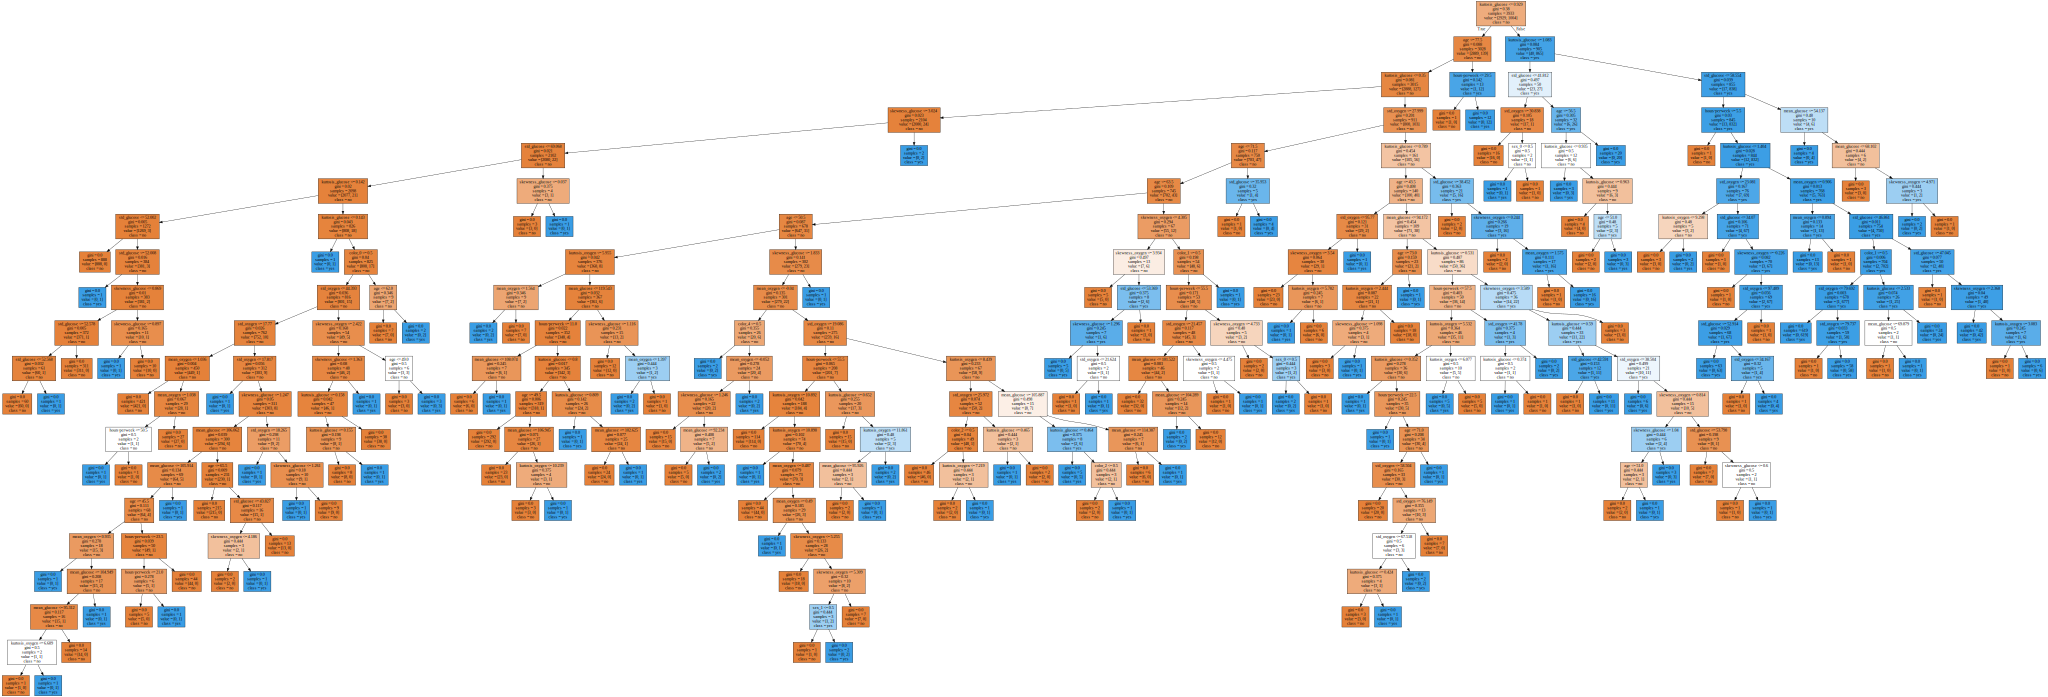

In [309]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

graph = Source(export_graphviz(cls, 
                               out_file=None,
                               feature_names=colTest,
                               class_names=['no', 'yes'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

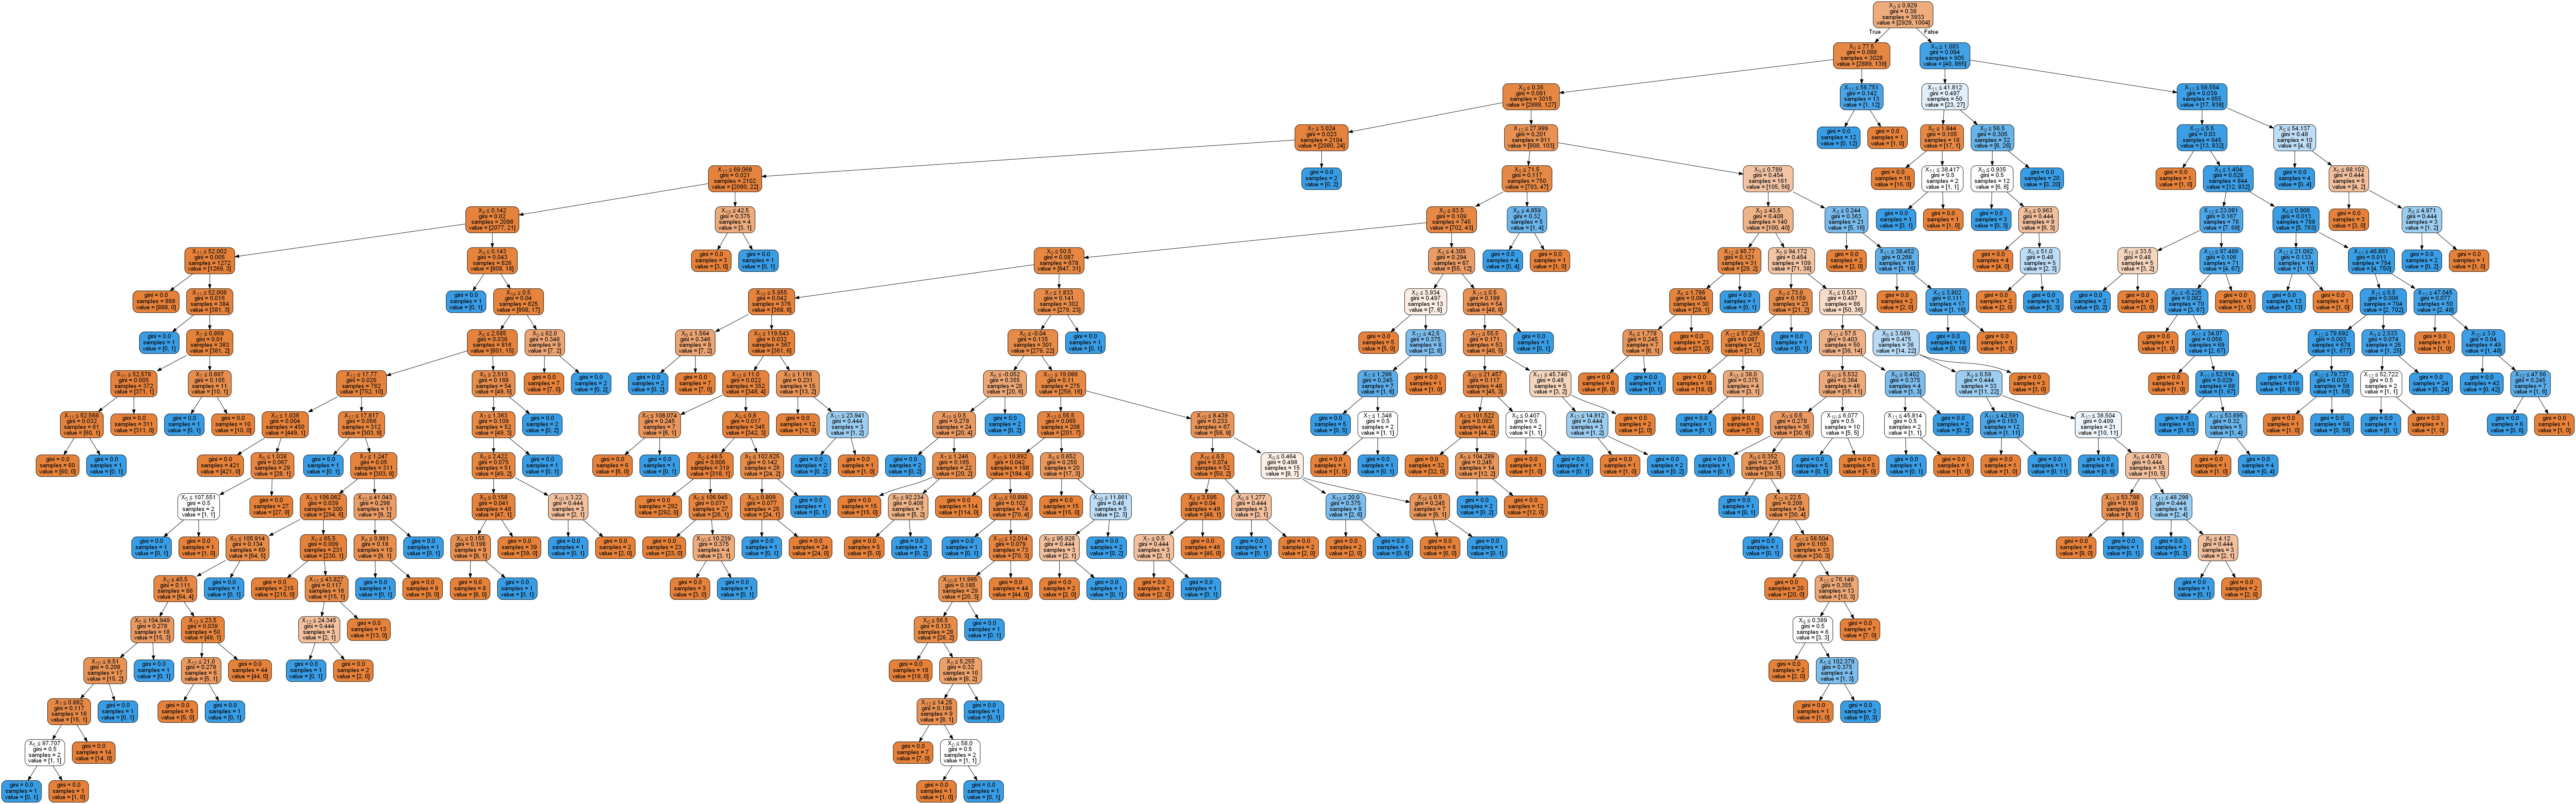

In [288]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
dot_data = StringIO()

export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Optimalizácia hyperparametrov

Pri nastavovaní hyperpyrametrov použijeme 10-násobnú krížovú validáciu. Ako prvý si nastavíme hyperparameter max-depth.

#### Cross-validation

In [366]:
cls2 = DecisionTreeClassifier()
model2 = cls2.fit(data, labels)

In [367]:
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
print("Accuracy:")
print("    Values: ",scores['test_accuracy'])
print("    Mean: ",scores['test_accuracy'].mean())
print("\nPrecision:")
print("    Values: ",scores['test_precision_macro'])
print("    Mean: ",scores['test_precision_macro'].mean())
print("\nRecall:")
print("    Values: ",scores['test_recall_macro'])
print("    Mean: ",scores['test_recall_macro'].mean())
print("\nF1: ")
print("    Values: ",scores['test_f1_macro'])
print("    Mean: ",scores['test_f1_macro'].mean())

Accuracy:
    Values:  [0.93654822 0.94162437 0.93908629 0.91624365 0.93129771 0.94910941
 0.91857506 0.94910941 0.93638677 0.93622449]
    Mean:  0.9354205399368258

Precision:
    Values:  [0.91188417 0.91833726 0.92011624 0.88759947 0.91053391 0.93543756
 0.8967803  0.93293515 0.91121032 0.91720964]
    Mean:  0.9142044037778245

Recall:
    Values:  [0.92489778 0.93155476 0.92011624 0.89502585 0.9078157  0.92964164
 0.88610922 0.93293515 0.92440273 0.91445205]
    Mean:  0.9166951125520706

F1: 
    Values:  [0.9180989  0.92465098 0.92011624 0.89121031 0.90916251 0.93248815
 0.8912487  0.93293515 0.91750976 0.91581841]
    Mean:  0.915323911295174


S použitím samotnej krížovej validácie, sme nedosiahli až tak lepšie výsledky ako bez nej, metrika accuracy má dokoncia o čosi horšie výsledky.

#### 1. Max depth
Hĺbka stromu do ktorej sa bude strom staviať.

In [360]:
def tryHyperMaxDepth(maxDepth):
    bestA = 0
    runA = 0
    bestP = 0
    runP = 0
    bestR = 0
    runR = 0
    bestF = 0
    runF = 0
    for x in range(1, maxDepth):
        cls2 = DecisionTreeClassifier(criterion='entropy',max_depth = x)
        model2 = cls2.fit(data, labels)
        scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
        scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
        test = dataValid
        pred = cls2.predict(test)
        print("Max-depth: ",x)
        print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
        print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
        print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
        print("F1: ",sm.f1_score(labelsValid, pred, average='macro'))
        print()
        if(sm.accuracy_score(labelsValid, pred) > bestA):
            runA = x
            bestA = sm.accuracy_score(labelsValid, pred)
        if(sm.precision_score(labelsValid, pred) > bestP):
            runP = x
            bestP = sm.precision_score(labelsValid, pred)
        if(sm.recall_score(labelsValid, pred) > bestR):
            runR = x
            bestR = sm.recall_score(labelsValid, pred)
        if(sm.f1_score(labelsValid, pred) > bestF):
            runF = x
            bestF = sm.f1_score(labelsValid, pred)
    return runA,runP,runR,runF

In [361]:
bestRunA,bestRunP,bestRunR,bestRunF = tryHyperMaxDepth(15)

Max-depth:  1
Accuracy:  0.9519450800915332
Precision:  0.9422391118179594
Recall:  0.9330602893168409
F1:  0.9375157453240642

Max-depth:  2
Accuracy:  0.9519450800915332
Precision:  0.9422391118179594
Recall:  0.9330602893168409
F1:  0.9375157453240642

Max-depth:  3
Accuracy:  0.9633867276887872
Precision:  0.9612687241132323
Recall:  0.9436131660127587
F1:  0.951978021978022

Max-depth:  4
Accuracy:  0.9664378337147216
Precision:  0.9617183238436127
Recall:  0.9512474168139208
F1:  0.9563185315320774

Max-depth:  5
Accuracy:  0.9633867276887872
Precision:  0.9552144544738596
Recall:  0.9501018299439935
F1:  0.9526178830445992

Max-depth:  6
Accuracy:  0.9633867276887872
Precision:  0.9577007704141359
Recall:  0.9473209739734643
F1:  0.9523474889440844

Max-depth:  7
Accuracy:  0.9610983981693364
Precision:  0.9534423192927084
Recall:  0.9457665698283866
F1:  0.9495136056758967

Max-depth:  8
Accuracy:  0.9549961861174676
Precision:  0.9410343779971286
Recall:  0.9434753960885321
F1

In [377]:
print("Best run accuracy: ",bestRunA)
print("Best run precision: ",bestRunP)
print("Best run recall: ",bestRunR)
print("Best run f1: ",bestRunF)

Best run accuracy:  4
Best run precision:  3
Best run recall:  5
Best run f1:  4


In [ ]:
cls2 = DecisionTreeClassifier(criterion='entropy',max_depth = 4)
model2 = cls2.fit(data, labels)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)

Najlepšie výsledky sme dosiahli s hĺbkou stromu 4, pretože až dve metriky dosiali najlepšie výsledky pre hĺbku stromu 4 pričom ostatné dve metriky, ktorá mali najlepšie výsledky pri ostatných dvoch hĺbkach neboli o nič vyššie ako pri hĺbke 4, čiže hyperparameter max_depth budeme ďalej používať s hodnotou 4. Taktiež si môžeme pozorovať, že s narastajúcpu hĺbkou stromu sa nám výsledky zhoršovali.

In [370]:
test = dataValid
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9664378337147216
Precision:  0.9617183238436127
Recall:  0.9512474168139208
F1:  0.9563185315320774


#### 2. Number of leaves
Počet listov v strome.

In [375]:
def tryHyperNumberOfLeaves(leavesNumber):
    bestA = 0
    runA = 0
    bestP = 0
    runP = 0
    bestR = 0
    runR = 0
    bestF = 0
    runF = 0
    for x in range(2, leavesNumber):
        cls2 = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes = x)
        model2 = cls2.fit(data, labels)
        scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
        scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
        test = dataValid
        pred = cls2.predict(test)
        print("Max-depth: ",x)
        print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
        print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
        print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
        print("F1: ",sm.f1_score(labelsValid, pred, average='macro'))
        print()
        if(sm.accuracy_score(labelsValid, pred) > bestA):
            runA = x
            bestA = sm.accuracy_score(labelsValid, pred)
        if(sm.precision_score(labelsValid, pred) > bestP):
            runP = x
            bestP = sm.precision_score(labelsValid, pred)
        if(sm.recall_score(labelsValid, pred) > bestR):
            runR = x
            bestR = sm.recall_score(labelsValid, pred)
        if(sm.f1_score(labelsValid, pred) > bestF):
            runF = x
            bestF = sm.f1_score(labelsValid, pred)
    return runA,runP,runR,runF

In [379]:
bestRunA,bestRunP,bestRunR,bestRunF = tryHyperNumberOfLeaves(30)

Max-depth:  2
Accuracy:  0.9519450800915332
Precision:  0.9422391118179594
Recall:  0.9330602893168409
F1:  0.9375157453240642

Max-depth:  3
Accuracy:  0.9519450800915332
Precision:  0.9422391118179594
Recall:  0.9330602893168409
F1:  0.9375157453240642

Max-depth:  4
Accuracy:  0.9519450800915332
Precision:  0.9422391118179594
Recall:  0.9330602893168409
F1:  0.9375157453240642

Max-depth:  5
Accuracy:  0.9519450800915332
Precision:  0.9422391118179594
Recall:  0.9330602893168409
F1:  0.9375157453240642

Max-depth:  6
Accuracy:  0.954233409610984
Precision:  0.9440667246422643
Recall:  0.9373955494324477
F1:  0.9406604747162023

Max-depth:  7
Accuracy:  0.9633867276887872
Precision:  0.9612687241132323
Recall:  0.9436131660127587
F1:  0.951978021978022

Max-depth:  8
Accuracy:  0.9633867276887872
Precision:  0.9612687241132323
Recall:  0.9436131660127587
F1:  0.951978021978022

Max-depth:  9
Accuracy:  0.9633867276887872
Precision:  0.9612687241132323
Recall:  0.9436131660127587
F1: 

In [380]:
print("Best run accuracy: ",bestRunA)
print("Best run precision: ",bestRunP)
print("Best run recall: ",bestRunR)
print("Best run f1: ",bestRunF)

Best run accuracy:  14
Best run precision:  7
Best run recall:  24
Best run f1:  14


Najlepšie výsledky sme dosiahli s počtom listov  14, pretože až dve metriky dosiali najlepšie výsledky pre daný počet. Ďalej budeme hyperparameter max_leaf_nodes používať s hodnotou 14.

In [381]:
cls2 = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes = 14)
model2 = cls2.fit(data, labels)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)

In [382]:
test = dataValid
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9672006102212052
Precision:  0.9597696284427246
Recall:  0.9554733594896523
F1:  0.9575934012615236


Teraz skúsime spojiť tieto dva parametre podľa najepších výsledkov a následne ešte skúsim rôzne kombinácie, aby som si potvrdil, že tieto dva sú najlepšie.

In [383]:
cls2 = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes = 14, max_depth= 4)
model2 = cls2.fit(data, labels)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)

In [384]:
test = dataValid
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9664378337147216
Precision:  0.9617183238436127
Recall:  0.9512474168139208
F1:  0.9563185315320774


Spojením sme nedosiali lepšie výsledky ako pri samotnom použití parametru max_leaf_nodes.

In [405]:
def tryCombination(leavesNumber,maxDepth):
    bestA = 0
    runAx = 0
    runAy = 0
    bestP = 0
    runPx = 0
    runPy = 0
    bestR = 0
    runRx = 0
    runRy = 0
    bestF = 0
    runFx = 0
    runFy = 0
    for x in range(1, maxDepth):
        for y in range(2, leavesNumber):
            cls2 = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes = y, max_depth= x)
            model2 = cls2.fit(data, labels)
            scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
            scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
            test = dataValid
            pred = cls2.predict(test)
            if(sm.accuracy_score(labelsValid, pred) > bestA):
                runAx = x
                runAy = y
                bestA = sm.accuracy_score(labelsValid, pred)
            if(sm.precision_score(labelsValid, pred) > bestP):
                runPx = x
                runPy = y
                bestP = sm.precision_score(labelsValid, pred)
            if(sm.recall_score(labelsValid, pred) > bestR):
                runRx = x
                runRy = y
                bestR = sm.recall_score(labelsValid, pred)
            if(sm.f1_score(labelsValid, pred) > bestF):
                runFx = x
                runFy = y
                bestF = sm.f1_score(labelsValid, pred)
    return runAx,runAy,runPx,runPy,runRx,runRy,runFx,runFy

In [406]:
runAx,runAy,runPx,runPy,runRx,runRy,runFx,runFy = tryCombination(20,8)

In [407]:
print("Depth/Nodes")
print("Best run accuracy: ",runAx,"/",runAy)
print("Best run precision: ",runPx,"/",runPy)
print("Best run recall: ",runRx,"/",runRy)
print("Best run f1: ",runFx,"/",runFy)

Depth/Nodes
Best run accuracy:  5 / 14
Best run precision:  3 / 7
Best run recall:  5 / 14
Best run f1:  5 / 14


Ako vidíme kombináciou max_depth 5 a max_leaf_nodes 14 sme dosiahli pre tri metriky nejlepšie výsledky. Preto budeme ďalej pokračovať s danými číslami. Čo znamená, že max_depth sa nám zmení z 4 na 5.

In [409]:
cls2 = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes = 14, max_depth= 5)
model2 = cls2.fit(data, labels)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
test = dataValid
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9672006102212052
Precision:  0.9597696284427246
Recall:  0.9554733594896523
F1:  0.9575934012615236


#### 3. Class weight
keď algoritmus vypočíta entropiu, aby sa rozdelil v uzle, výsledné podriadené uzly sa vážia váhou class_weight, čím sa podradeným váham priradia váhy na základe zadaného podielu triedy.

In [526]:
def tryHyperWeightClass():
    bestA = 0
    runAx = 0
    runAy = 0
    bestP = 0
    runPx = 0
    runPy = 0
    bestR = 0
    runRx = 0
    runRy = 0
    bestF = 0
    runFx = 0
    runFy = 0
    maxX = 31;
    maxY = 31;
    for x in range(1,maxX):
        zeroWeight = x;
        for y in range(1,maxY):
            oneWeight = y;
            cls2 = DecisionTreeClassifier(criterion='entropy',class_weight = {0: zeroWeight, 1: oneWeight})
            model2 = cls2.fit(data, labels)
            scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
            scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
            test = dataValid
            pred = cls2.predict(test)
            if(sm.accuracy_score(labelsValid, pred) > bestA):
                runAx = x
                runAy = y
                bestA = sm.accuracy_score(labelsValid, pred)
            if(sm.precision_score(labelsValid, pred) > bestP):
                runPx = x
                runPy = y
                bestP = sm.precision_score(labelsValid, pred)
            if(sm.recall_score(labelsValid, pred) > bestR):
                runRx = x
                runRy = y
                bestR = sm.recall_score(labelsValid, pred)
            if(sm.f1_score(labelsValid, pred) > bestF):
                runFx = x
                runFy = y
                bestF = sm.f1_score(labelsValid, pred)
            clear_output(wait=True)
            print("Progress: ",(x-1)*(maxY-1)+y,"/",(maxX-1)*(maxY-1),"models")
    return runAx,runAy,runPx,runPy,runRx,runRy,runFx,runFy

In [478]:
runAx,runAy,runPx,runPy,runRx,runRy,runFx,runFy = tryHyperWeightClass()

In [480]:
print("Class weight for zero/one")
print("Best run accuracy: ",runAx,"/",runAy)
print("Best run precision: ",runPx,"/",runPy)
print("Best run recall: ",runRx,"/",runRy)
print("Best run f1: ",runFx,"/",runFy)

Class weight for zero/one
Best run accuracy:  25 / 14
Best run precision:  2 / 29
Best run recall:  8 / 25
Best run f1:  27 / 15


In [481]:
cls2 = DecisionTreeClassifier(criterion='entropy',class_weight = {0:25,1:14})
model2 = cls2.fit(data, labels)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
test = dataValid
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9488939740655988
Precision:  0.9301090213244072
Recall:  0.9402572703585013
F1:  0.9350070478029722


Triede 1 priradím váhu 14 a triede 0 váhu 25 čo znamená, že každých 25 inštancií treidy 0 sa bude brať do úvahy ako 16 inštancií triedy 1.
Ďalej si spojíme všetky hyperparametre a uvidíme výsledok. Pri ďalšom postupe už nebudem robiť kombinácie všetkých možností, to by už trvalo značný čas, budem dávať čísla, ktorí dosiahli najlepšie výsledky pre jednotilé heyperparametre, avšak vyskúšam manuálne aj iné hodnoty.

In [497]:
cls2 = DecisionTreeClassifier(criterion='entropy',class_weight = {0:25,1:14},max_leaf_nodes = 14, max_depth= 5)
model2 = cls2.fit(data, labels)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
test = dataValid
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9610983981693364
Precision:  0.9518426701333252
Recall:  0.9476204738087395
F1:  0.9497038014962256


Keďže celkové dosiahnuté výsledky sú horšie, tento hyperparameter pravdepodobne nebudem brať do úvahy pre finálnu verziu modelu. Aj keď rozdiel výsledkov nie  je až taký veľký. Každopádne pri ďalšom skúšaní ešte s týmto hyperparametrom budem počítať. 

Vyskúšame si ešte váhy dopočítať pomocou funkcie compute_class_weight.

In [541]:
from sklearn.utils import class_weight
import math
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_dataset['class']),labels)
class_weights

array([0.67138955, 1.95866534])

In [556]:
a = (1/ class_weights[0]) * class_weights[1]
a

2.9173306772908365

In [557]:
cls2 = DecisionTreeClassifier(criterion='entropy',class_weight = {0:1,1:3},max_leaf_nodes = 14, max_depth= 5)
model2 = cls2.fit(data, labels)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
test = dataValid
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9572845156369184
Precision:  0.9397388352962409
Recall:  0.9524454161550211
F1:  0.9458229282893222


Výsledky sa stále nezlepšili.

#### 4. Splitter
Stratégia podľa ktorej sa budú rozdeľovať uzly.

In [558]:
cls2 = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes = 14, max_depth= 5,splitter = "best")
model2 = cls2.fit(data, labels)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
test = dataValid
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9672006102212052
Precision:  0.9597696284427246
Recall:  0.9554733594896523
F1:  0.9575934012615236


In [559]:
cls2 = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes = 14, max_depth= 5,splitter = "random")
model2 = cls2.fit(data, labels)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
test = dataValid
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9595728451563692
Precision:  0.9522632737949597
Recall:  0.942876396417982
F1:  0.9474338809869112


Lepšie výsledky máme pre rozdelovanie uzlov podľa najlepších výsledkov.

Rôzne dalšie hyperparametre.

In [573]:
cls2 = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes = 14, max_depth= 5,min_samples_split=3)
model2 = cls2.fit(data, labels)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
test = dataValid
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9672006102212052
Precision:  0.9597696284427246
Recall:  0.9554733594896523
F1:  0.9575934012615236


In [576]:
cls2 = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes = 14, max_depth= 5,min_samples_leaf= 2)
model2 = cls2.fit(data, labels)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
test = dataValid
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9672006102212052
Precision:  0.9597696284427246
Recall:  0.9554733594896523
F1:  0.9575934012615236


Vyskúšali sme ešte dalľie hyperparametre ako  min_samples_leaf, max_features a iné no žiadne nám nezlepšili výslednú hodnoty po väčšine prípadov boli najlepšie defaultne nastavenia

### Výsledok

Výsledky manuálneho kalsifikátora
 * Accuracy : 0.8771929824561403
 * Precision : 0.8387145495658779
 * Recall : 0.8526206235586571
 * F1 : 0.8443741316747466
  
Rozhodovací strom bez optimalizácie pomocou hyperparametrov:
 * Accuracy:  0.9405034324942791
 * Precision:  0.9192867157378198
 * Recall:  0.9299230285423343
 * F1: 0.9244043007445871

Rozhodovací strom s optimalizáciou pomocou hyperparametrov:
 * Accuracy:  0.9672006102212052
 * Precision:  0.9597696284427246
 * Recall:  0.9554733594896523
 * F1:  0.9575934012615236
 
Výsledný rozdiel medzi stromom a manuálnym klasifikátorom je vcelku veľký až do 10%.

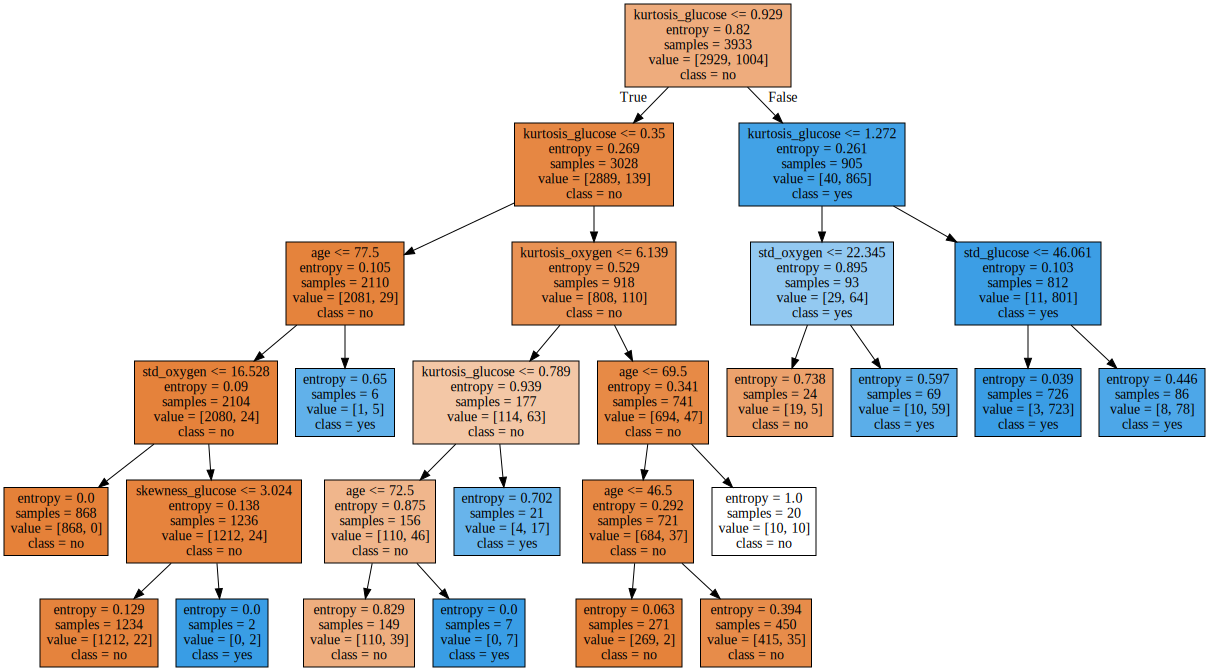

In [605]:
graph = Source(export_graphviz(cls2, 
                               out_file=None,
                               feature_names=colTest,
                               class_names=['no', 'yes'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

### Vyhodnotenie vplyvu zvolenej stratégie doplnenia chýbajúcich hodnôt na správnosť klasifikácie.

A keďže strom dosiahol lepšie výsledky ako manuálny klasifikátor, na rozhodovaciom strome budeme porovnávať stratégie riešenie chýbajúcich hodnôt. Keďže v datasete chýbalo veľa hodnôt iba pri atribúte 'mean_glucose' na daný atribút použijeme dve rôzne metódy. A to metódu doplennie chýbajúcich hodnôt podľa mediánu a doplnenie chýbajúcich hodnôt na priemer podľa segmentu, čo bude v našom prípade pohlavie.

Keďe pri doterajšom riešní bola použitá stratégia doplnenia chýbajúcich hodnôt pomocou priemeru segmentu, na porovnanie nám stačí spraviť doplnenie chýbajúcich hodnôt podľa priemeru.

#### 1. výsledky pre priemer podľa segmentu

In [652]:
cls2 = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes = 14, max_depth= 5)
model2 = cls2.fit(data, labels)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
test = dataValid
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9672006102212052
Precision:  0.9597696284427246
Recall:  0.9554733594896523
F1:  0.9575934012615236


In [653]:
dataValid['mean_glucose'].sum()

132418.71842072794

#### 2. výsledky pre doplnenie podľa mediánu
Na dosiahnutie daného výsledku som musel na chvíľu pozmeniť funkciu missingDataProcessing(), kde som nastavilaby sa atribút mean_glucose nespracoval. Teraz ho spracujem inou metódou.

In [646]:
train_for_tree = pd.read_csv("merged_train.csv", lineterminator='#')
valid_for_tree = finalFunction(personal_valid, other_valid)
setMissingValuesToMedian(valid_for_tree,'mean_glucose')
train_for_tree = encodeOneHot(train_for_tree)
valid_for_tree = encodeOneHot(valid_for_tree)

colForTrain = list(train_for_tree)
colForValid = list(valid_for_tree)


colTest = ['age','sex_0','sex_1','pregnant_0','pregnant_1','mean_glucose','mean_oxygen','skewness_glucose','skewness_oxygen',
          'kurtosis_glucose','kurtosis_oxygen','std_glucose','std_oxygen','hours-per-week','color_0','color_1','color_2','color_3',
          'color_4']

removeEncodedColumnsFromList(colForTrain)
removeEncodedColumnsFromList(colForValid)

labels = train_for_tree['class'].values
data = train_for_tree[colTest]

labelsValid = valid_for_tree['class'].values
dataValid = valid_for_tree[colTest]

C:\Users\Owner\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [649]:
dataValid['mean_glucose'].sum()

133142.034375

In [648]:
cls2 = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes = 14, max_depth= 5)
model2 = cls2.fit(data, labels)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(cls2, data, labels,scoring=scoring, cv=10)
test = dataValid
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(labelsValid, pred))
print("Precision: ",sm.precision_score(labelsValid, pred, average='macro')) 
print("Recall: ",sm.recall_score(labelsValid, pred, average='macro')) 
print("F1: ",sm.f1_score(labelsValid, pred, average='macro')) 

Accuracy:  0.9672006102212052
Precision:  0.9597696284427246
Recall:  0.9554733594896523
F1:  0.9575934012615236


Ako môžeme vidieť, suma hodnôt je rozdielna, čiže určite boli doplnené hodnoty iným spôsobom, ale rozdiel vo výsledných hodnotách je nulový, čo pripisujem tomu, že chábajúcich hodnlt bola pre validačný dataset príliš málo, a dané metódy pozmenuli dáta v minimálnej miere. Ale pre istotu to vyskúšame aj pre náš manuálny klasifikátor.

Použitie metódy priemer podľa segmentu.

In [656]:
valid = finalFunction(personal_valid, other_valid)
gpd = valid.loc[valid['class'] == 1,'mean_glucose']
gnd = valid.loc[valid['class'] == 0,'mean_glucose']
predictedTrainG = train_dataset[['class','mean_glucose']].copy()
predictedValidG = valid[['class','mean_glucose']].copy()
predictedTrainG['predicted'] = 0
predictedValidG['predicted'] = 0
predictionDiabetesFromGlucose(predictedTrainG)
predictionDiabetesFromGlucose(predictedValidG)
scoresOfPredictions(valid,predictedValidG,0)

Výsledky pre validačný dataset
   * Accuracy score: 0.8764302059496567
   * Precision score: 0.8376611999885113
   * Recall score: 0.852102488843631
   * F1 score: 0.8443741316747466


C:\Users\Owner\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Doplnenie na medián.

In [670]:
valid = finalFunction(personal_valid, other_valid)
setMissingValuesToMedian(valid,'mean_glucose')
gpd = valid.loc[valid['class'] == 1,'mean_glucose']
gnd = valid.loc[valid['class'] == 0,'mean_glucose']
predictedTrainG = train_dataset[['class','mean_glucose']].copy()
predictedValidG = valid[['class','mean_glucose']].copy()
predictedTrainG['predicted'] = 0
predictedValidG['predicted'] = 0
predictionDiabetesFromGlucose(predictedTrainG)
predictionDiabetesFromGlucose(predictedValidG)
scoresOfPredictions(valid,predictedValidG,0)

Výsledky pre validačný dataset
   * Accuracy score: 0.8764302059496567
   * Precision score: 0.8376611999885113
   * Recall score: 0.852102488843631
   * F1 score: 0.8443741316747466


C:\Users\Owner\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Ani pri tejto metóde nevidím rozdiel preto budem používať metódu 1, ktorú som používal aj doteraz.

### TEST DATA

In [936]:
test = finalFunction(personal_test, other_test)
col = ['color']
for c in col:
    test[c]=labelEncoder(test[c])
    X = encoder.fit_transform(test[c].values.reshape(-1,1)).toarray()
    dfOneHot = pd.DataFrame(X, columns = [c+"_"+str(int(i)) for i in range(X.shape[1])])
    test = pd.concat([test, dfOneHot], axis=1)
    del test[c]

In [810]:
ids = test[(test['pregnant_1'] > 0)]
ids = [1283,1288,1291]

In [947]:
sexList = {'Male': 1, 'Female': 0}
pregnantList = {'t': 1, 'f': 0}

One hot encoding mi vytvoril 3 záznamy navyše, a nieako mi posúvalo lable, tak si nakoniec tie ktoré sa mi javili zlé ručne nastavím podľa toho čo by mali byť.

In [974]:
train_for_tree = pd.read_csv("merged_train.csv", lineterminator='#')
test = finalFunction(personal_test, other_test)

col = ['color']
for c in col:
    test[c]=labelEncoder(test[c])
    X = encoder.fit_transform(test[c].values.reshape(-1,1)).toarray()
    dfOneHot = pd.DataFrame(X, columns = [c+"_"+str(int(i)) for i in range(X.shape[1])])
    test = pd.concat([test, dfOneHot], axis=1)
    del test[c]
    
for c in col:
    train_for_tree[c]=labelEncoder(train_for_tree[c])
    X = encoder.fit_transform(train_for_tree[c].values.reshape(-1,1)).toarray()
    dfOneHot = pd.DataFrame(X, columns = [c+"_"+str(int(i)) for i in range(X.shape[1])])
    train_for_tree = pd.concat([train_for_tree, dfOneHot], axis=1)
    del train_for_tree[c]
train_for_tree['class']=labelEncoder(train_for_tree['class'])

train_for_tree['sex'] = [sexList[item] for item in train_for_tree['sex']]
train_for_tree['pregnant'] = [pregnantList[item] for item in train_for_tree['pregnant']]

test = test.drop(1283)
test = test.drop(1288)
test = test.drop(1291)  

test['sex'] = [sexList[item] for item in test['sex']]
test['pregnant'] = [pregnantList[item] for item in test['pregnant']]
  
test['color_4'][1309] = 1.0
test['color_4'][1310] = 1.0
test['color_4'][1311] = 1.0
test['color_3'][1309] = 0.0
test['color_3'][1310] = 0.0
test['color_3'][1311] = 0.0
test['color_2'][1309] = 0.0
test['color_2'][1310] = 0.0
test['color_2'][1311] = 0.0
test['color_1'][1309] = 0.0
test['color_1'][1310] = 0.0
test['color_1'][1311] = 0.0
test['color_0'][1309] = 0.0
test['color_0'][1310] = 0.0
test['color_0'][1311] = 0.0
    
cols = ['name','age','sex','pregnant','mean_glucose','mean_oxygen','skewness_glucose','skewness_oxygen',
          'kurtosis_glucose','kurtosis_oxygen','std_glucose','std_oxygen','hours-per-week','color_0','color_1','color_2','color_3',
          'color_4']
labels = train_for_tree['class'].values
data = train_for_tree[cols]
dataTest = test[cols]

predictedTest = test[['name']].copy()
predictedTest['predicted'] = 0

del dataTest['name']
del data['name']


C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value i

In [975]:
predictedTest

,name,predicted
0,Randy Jones,0
1,Earl Montville,0
2,Patrick Skinner,0
3,Paul Francois,0
4,Kenneth Blair,0
...,...,...
1307,Travis Hardy,0
1308,Walter Aderholt,0
1309,Walter Mulrooney,0
1310,William Hazelrigg,0


In [976]:
cls2 = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes = 14, max_depth= 5)
model2 = cls2.fit(data, labels)

In [977]:
test = dataTest
predictedTest['predicted'] = cls2.predict(test)

In [978]:
predictedTest

,name,predicted
0,Randy Jones,0
1,Earl Montville,0
2,Patrick Skinner,0
3,Paul Francois,0
4,Kenneth Blair,0
...,...,...
1307,Travis Hardy,1
1308,Walter Aderholt,0
1309,Walter Mulrooney,0
1310,William Hazelrigg,0
